In [1]:
## import packages

import os
import numpy as np
import pandas as pd
from scipy import stats

import geopandas as gpd

import xarray as xr
import rioxarray as rxr
import rasterio as rio
import matplotlib.pyplot as plt

from isofit.inversion.inverse_simple import invert_liquid_water

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['figure.dpi'] = 300

c:\Users\jeanallen\Miniconda3\envs\rs\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# seed for random number generator
np.random.seed(91) # did you know that 91 is the first non-trivial composite number?

In [3]:
## Lists of GLTs that correspond to a given date
# @jean: 2022-02-24 didn't show up in the SHIFT Ecosphere paper, but it is on the server? What's up with that?
# Also, I need to add 9/15 to this
date_list = ['20220224', '20220228',  '20220308', '20220316', '20220322', '20220405', '20220420', '20220429', '20220503', '20220511', '20220517', '20220529', '20220914']

# Directory structure...
glt_dir = 'D:/SHIFT/raw_imagery/glts'
all_glts = [f for f in os.listdir(glt_dir) if not f.endswith('.hdr')]
img_dir = 'D:/SHIFT/raw_imagery/L2A'
all_imgs = [f for f in os.listdir(img_dir) if not f.endswith('.hdr')]

# Shapefile containing TOI's (trees of interest)
sedgwick_path = ('C:/Users/jeanallen/Desktop/SHIFT_CWC/data/gis_data/sedgwick_boundary.shp')

In [4]:
# Retrieves spectrum from a given image/GLT combo at a given lat/lon
def get_pixel_value(image_path, glt_path, lat, lon, coords_epsg):
    image = rxr.open_rasterio(image_path)
    glt = rxr.open_rasterio(glt_path)
    glt_epsg = glt.rio.crs.to_epsg()
    if glt_epsg != coords_epsg:    # if the GLT and the input coordinates are in different projections, convert the coordinates to the GLT projection
        coords = gpd.GeoDataFrame({'geometry': gpd.points_from_xy([lon], [lat])}, crs=coords_epsg)
        coords = coords.to_crs(glt_epsg)
        lat = coords.geometry.y[0]
        lon = coords.geometry.x[0]
    try:
        closest_point = glt.sel(x=lon, y=lat, method='nearest', tolerance=2.5)
    except KeyError:
        none_object = (rxr.open_rasterio(image_path).wavelength.values, np.zeros(len(rxr.open_rasterio(image_path).wavelength.values)), 'No Data Available')    # return this if no data is found
        return none_object
    if (closest_point.values[0] == 0 and closest_point.values[1] == 0):
        none_object = (rxr.open_rasterio(image_path).wavelength.values, np.zeros(len(rxr.open_rasterio(image_path).wavelength.values)), 'No Data Available')    # return this if no data is found
        return none_object
    closest_x = int(closest_point[0].values[()])-1
    closest_y = int(closest_point[1].values[()])-1
    pixel_value = image.isel(x=closest_x, y=closest_y)
    return pixel_value

# Parses a list of GLTs and returns a list of spectra that correspond to the provided lat/lon, plus list of GLT that were used
# modified to actually only get the spectra where we DO have two examples of the same location
def find_and_get_pixel_value(list_of_img_paths, list_of_glt_paths, lat, lon, coords_epsg):
    list_of_img_paths.sort()
    list_of_glt_paths.sort()    # sort the lists to ensure that the GLT and image are from the same time
    none_object = (rxr.open_rasterio(list_of_img_paths[0]).wavelength.values, np.zeros(len(rxr.open_rasterio(list_of_img_paths[0]).wavelength.values)), 'No Data Available')    # return this if no data is found
    specs = []
    glts_used = []
    for i in range(len(list_of_img_paths)):
        try:
            this_val = get_pixel_value(list_of_img_paths[i], list_of_glt_paths[i], lat, lon, coords_epsg)
            if this_val[2] == 'No Data Available':
                continue
            specs.append(this_val)
            glts_used.append(list_of_glt_paths[i].split('\\')[-1])
        except IndexError:
            continue
    if len(specs) <= 1:
        return none_object

    if len(specs) > 1:
        # When there are two spectra for the same location, it is likely that one is the forward scattering and the other is the back scattering
        # We want the backscattering view, so we find the one that has the higher average reflectance in the NIR region
        # @jean I handle this better later in the notebook
        avg_refl = [stats.trim_mean(spec[130:145], 0.1) for spec in specs]
        back_scatter_spec = specs[avg_refl.index(max(avg_refl))]
        back_scatter_glt = glts_used[avg_refl.index(max(avg_refl))]
        fore_scatter_spec = specs[avg_refl.index(min(avg_refl))]
        fore_scatter_glt = glts_used[avg_refl.index(min(avg_refl))]
        return back_scatter_spec.wavelength.values, back_scatter_spec.values, back_scatter_glt, fore_scatter_spec.values, fore_scatter_glt

In [5]:
date = date_list[9]

glt_list = [glt for glt in all_glts if glt[3:11] == date]
img_list = [img for img in all_imgs if img[3:11] == date]

img_list = [os.path.join(img_dir, img) for img in img_list]
glt_list = [os.path.join(glt_dir, glt) for glt in glt_list]

glt_list.sort()
img_list.sort()

# get epsg of the imagery
coords_epsg = rxr.open_rasterio(glt_list[0]).rio.crs.to_epsg()

[[[ 769979.94495671]
  [3846655.62947402]]

 [[ 771753.55307225]
  [3845057.82409978]]

 [[ 770032.88209978]
  [3843622.85025977]]

 [[ 772074.86221596]
  [3848048.40718272]]

 [[ 771363.62604403]
  [3846249.42535764]]]


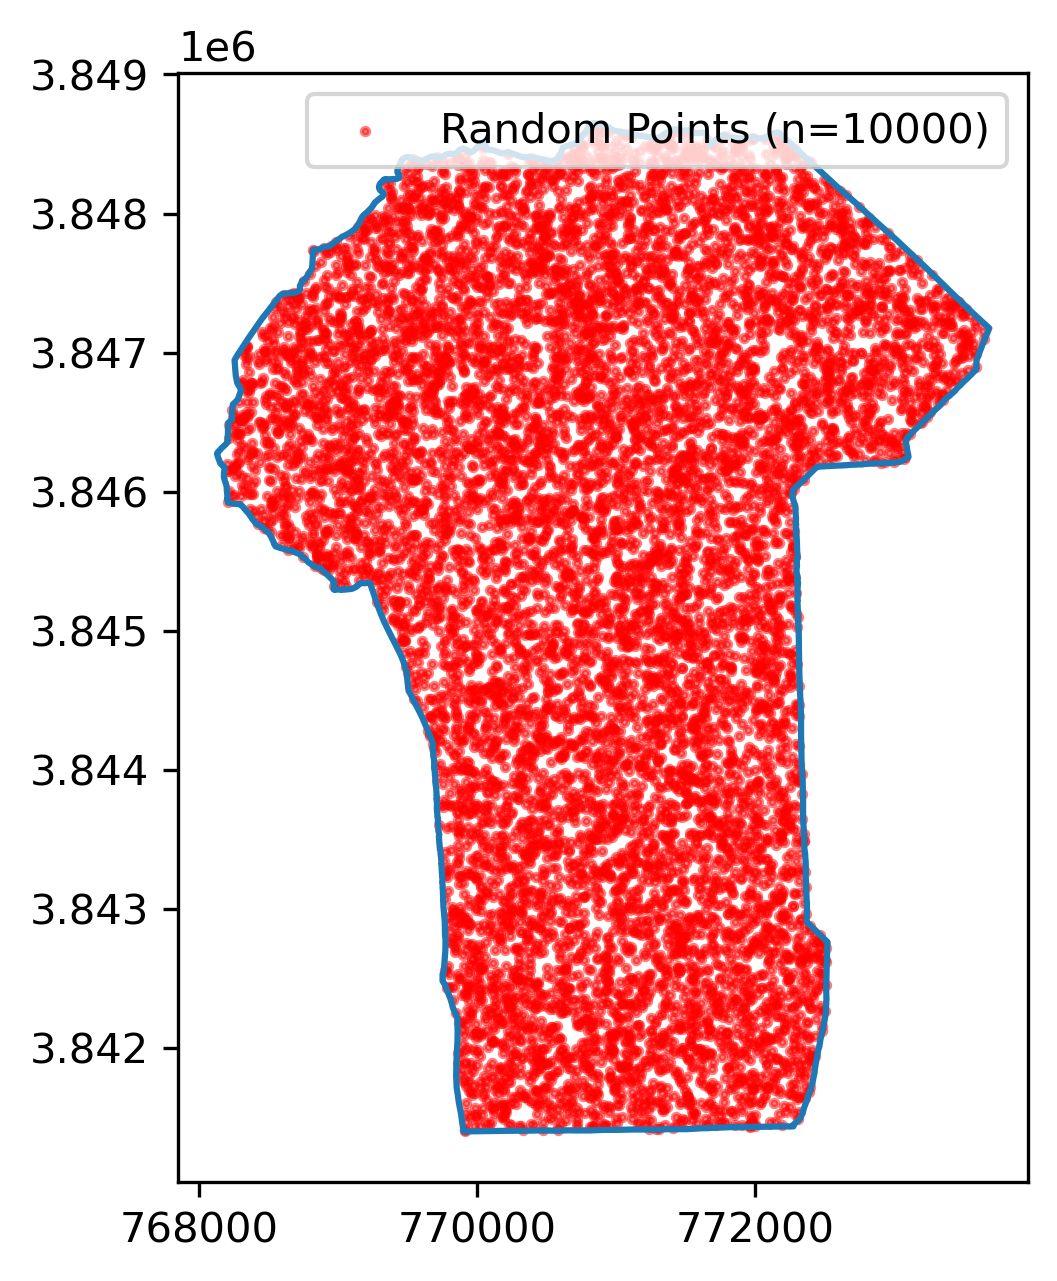

In [6]:
# open the shapefile
sedgwick = gpd.read_file(sedgwick_path)
sedgwick = sedgwick.to_crs(epsg=coords_epsg)

# plot
fig, ax = plt.subplots()
sedgwick.boundary.plot(ax=ax)

# make list of random points within the polygon
n_points = 10000
points = []
while len(points) < n_points:
    x = np.random.uniform(sedgwick.bounds.minx, sedgwick.bounds.maxx)
    y = np.random.uniform(sedgwick.bounds.miny, sedgwick.bounds.maxy)
    point = [x, y]
    if sedgwick.contains(gpd.points_from_xy([x], [y])[0]).values[0]:
        points.append(point)

# plot the points
points = np.array(points)
print(points[:5])
ax.scatter(points[:, 0], points[:, 1], c='red', s=3, alpha=0.5, label='Random Points (n=' + str(points.shape[0]) + ')')
ax.legend()
plt.show()

In [7]:
# get the spectra of each point
# runtime ~10-15 minutes
spectra = []
glts_used = []
for i, point in enumerate(points):
    if i % 100 == 0:
        print('Working on #',i)
    spectra.append(find_and_get_pixel_value(img_list, glt_list, point[1], point[0], coords_epsg))

# drop the points that didn't have any data
spectra = [spec for spec in spectra if spec[2] != 'No Data Available']
print('# of good spectra:', len(spectra))

Working on # 0
Working on # 100
Working on # 200
Working on # 300
Working on # 400
Working on # 500
Working on # 600
Working on # 700
Working on # 800
Working on # 900
Working on # 1000
Working on # 1100
Working on # 1200
Working on # 1300
Working on # 1400
Working on # 1500
Working on # 1600
Working on # 1700
Working on # 1800
Working on # 1900
Working on # 2000
Working on # 2100
Working on # 2200
Working on # 2300
Working on # 2400
Working on # 2500
Working on # 2600
Working on # 2700
Working on # 2800
Working on # 2900
Working on # 3000
Working on # 3100
Working on # 3200
Working on # 3300
Working on # 3400
Working on # 3500
Working on # 3600
Working on # 3700
Working on # 3800
Working on # 3900
Working on # 4000
Working on # 4100
Working on # 4200
Working on # 4300
Working on # 4400
Working on # 4500
Working on # 4600
Working on # 4700
Working on # 4800
Working on # 4900
Working on # 5000
Working on # 5100
Working on # 5200
Working on # 5300
Working on # 5400
Working on # 5500
Work

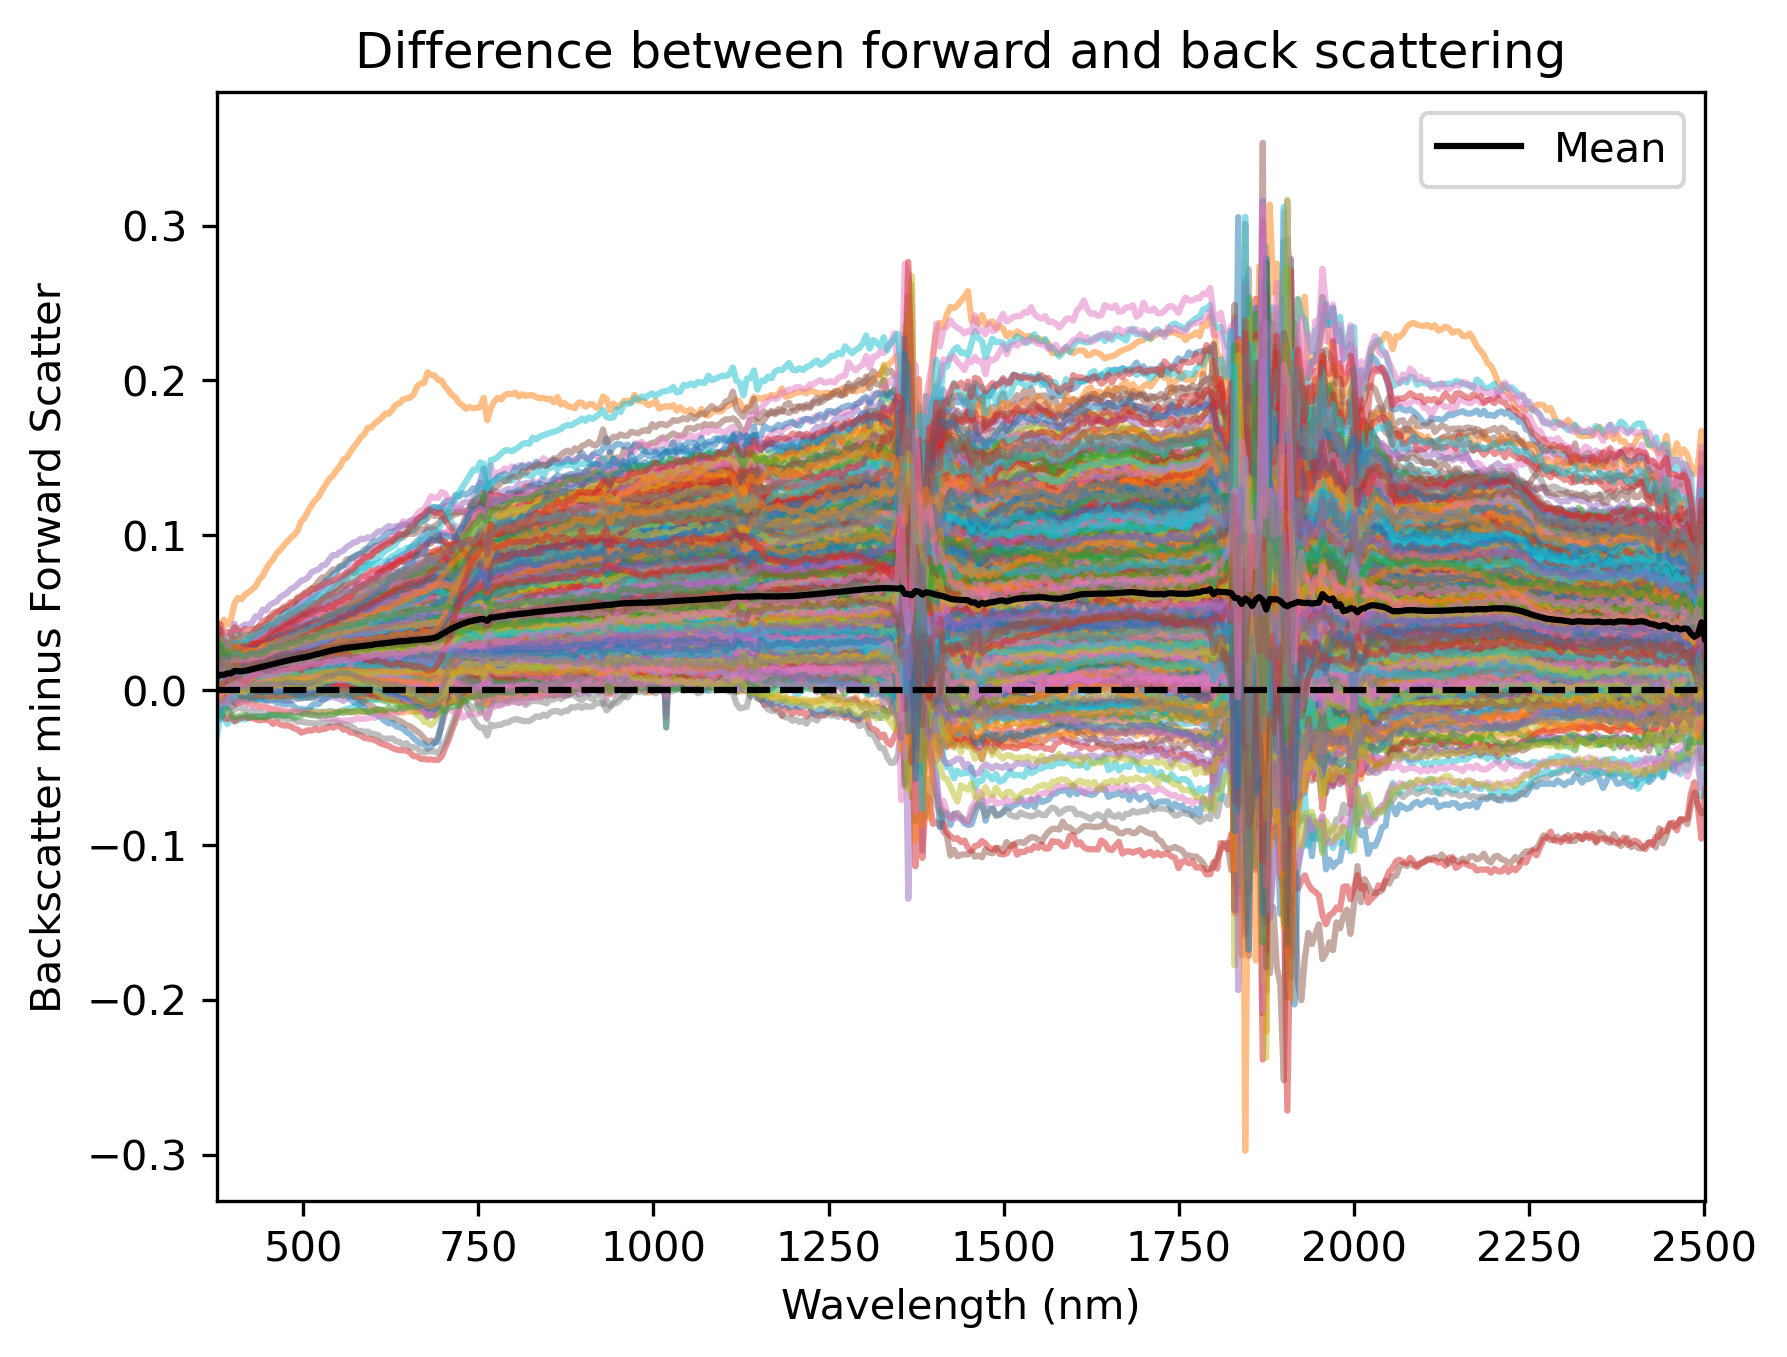

In [8]:
# plot difference between forward and back scattering for all spectra
fig, ax = plt.subplots()

for spec in spectra:
    ax.plot(spec[0], spec[1]-spec[3], alpha=0.5)
ax.set_title('Difference between forward and back scattering')
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Backscatter minus Forward Scatter')
ax.set_xlim(spec[0][0], spec[0][-1])

# calculate and plot mean difference
mean_spec = np.mean([spec[1]-spec[3] for spec in spectra], axis=0)
ax.plot(spec[0], mean_spec, color='black', label='Mean')
ax.axhline(0, color='black', linestyle='--')

ax.legend()
plt.show()

In [9]:
# calculate CWC for both the backscatter and forward scatter viewing geometries
# runtime ~6 minutes
cwc_backs = []
cwc_fores = []
for i, spec in enumerate(spectra):
    if i % 100 == 0:
        print('Working on #',i)
    cwc_back = invert_liquid_water(spec[1], spec[0], l_shoulder=1100, r_shoulder=1300)[0]
    cwc_fore = invert_liquid_water(spec[3], spec[0], l_shoulder=1100, r_shoulder=1300)[0]
    cwc_backs.append(cwc_back)
    cwc_fores.append(cwc_fore)

Working on # 0
Working on # 100
Working on # 200
Working on # 300
Working on # 400
Working on # 500
Working on # 600
Working on # 700
Working on # 800
Working on # 900
Working on # 1000
Working on # 1100
Working on # 1200
Working on # 1300
Working on # 1400
Working on # 1500
Working on # 1600
Working on # 1700


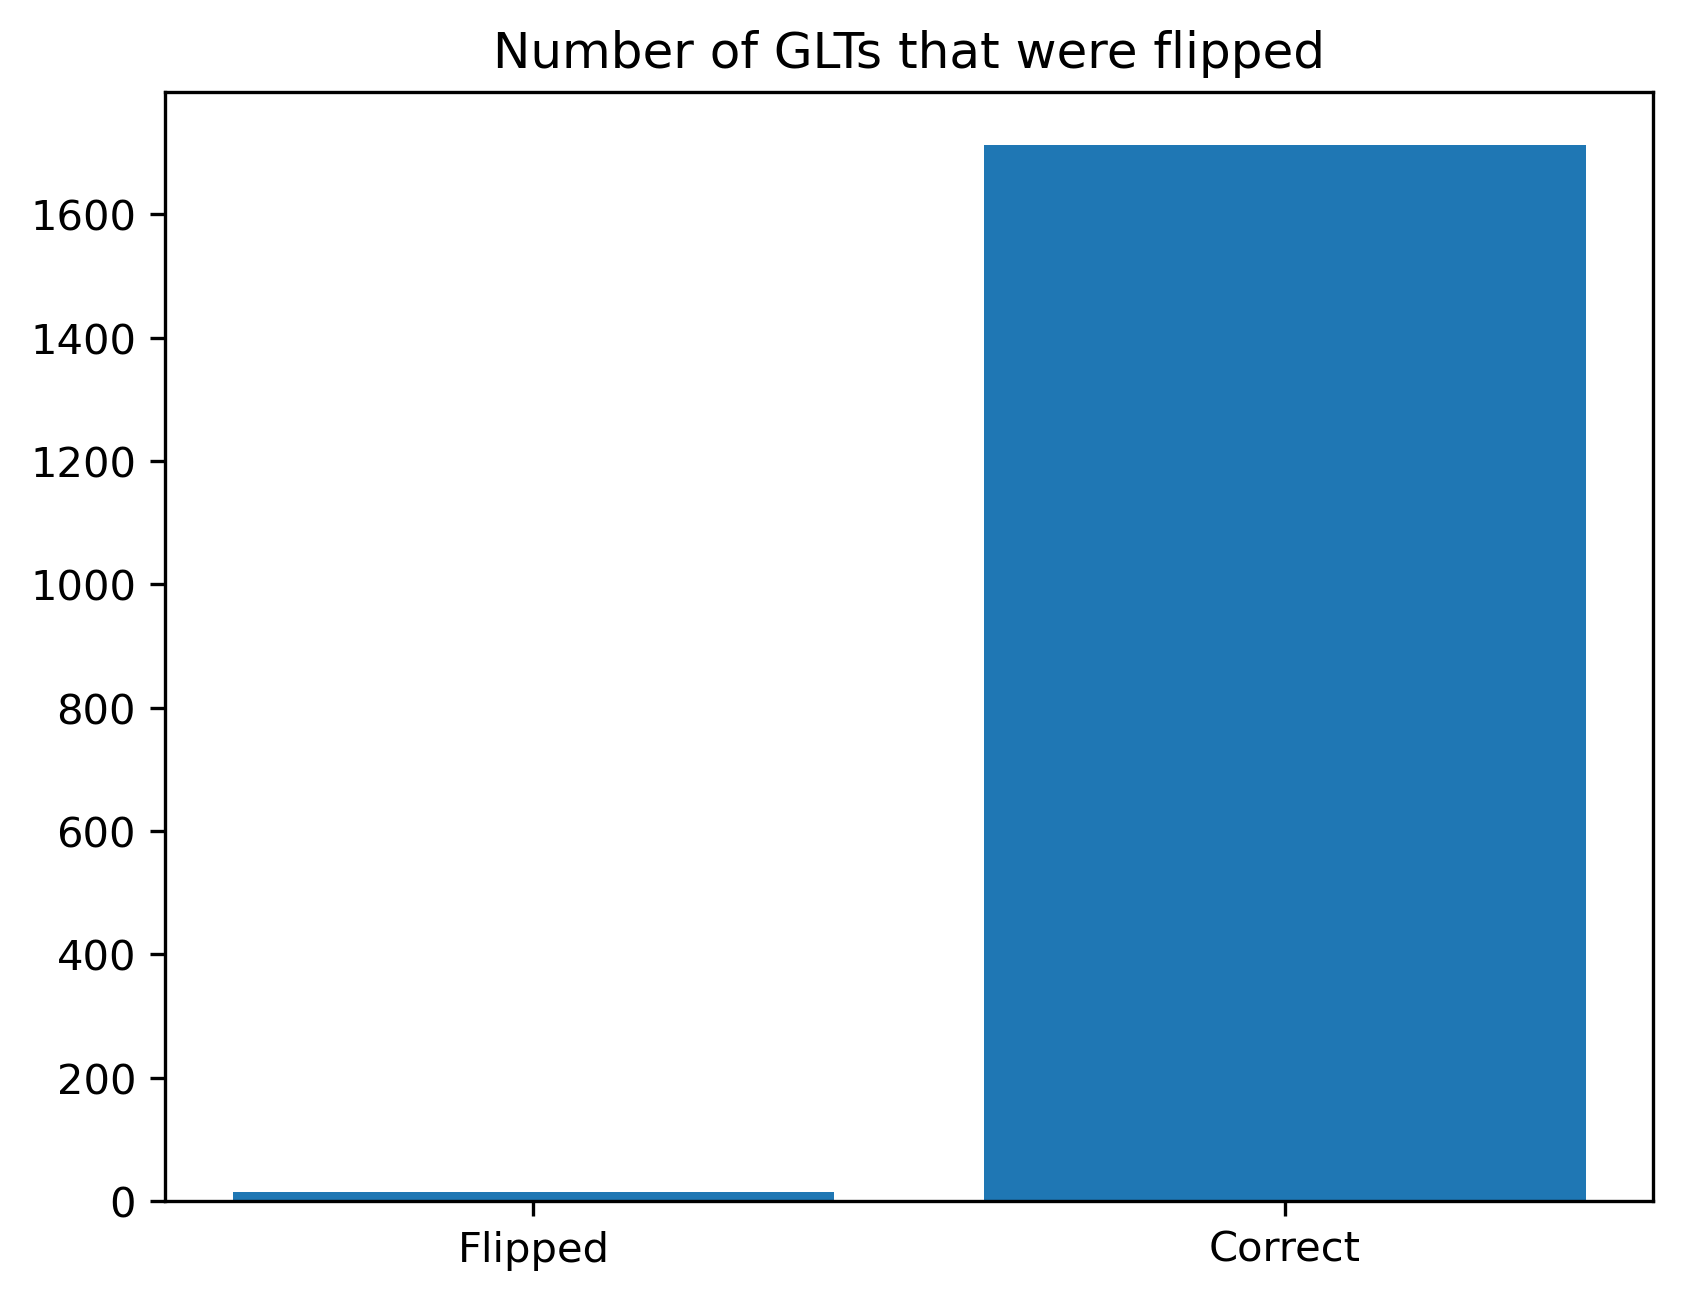

In [10]:
flip_flags = []
for spec in spectra:
    both_glts = [spec[2], spec[4]]

    # there are two possible combinations of GLTs: ['ang20220511t190344_glt', 'ang20220511t191813_glt'] and ['ang20220511t191813_glt', 'ang20220511t193135_glt']
    # if the GLTs are in the correct order, the NIR-based estimate of which one was backscattering was correct
    # if the GLTs are in the wrong order,then the darker NIR reflectance was actually the backscattering view
    list1 = ['ang20220511t191813_glt', 'ang20220511t193135_glt']
    list2 = ['ang20220511t190344_glt', 'ang20220511t191813_glt']

    # flip_flag indicates whether the GLTs were in the wrong order
    if both_glts == list1:
        flip_flag = False
    elif both_glts == list2:
        flip_flag = False
    elif both_glts == list1[::-1]:
        flip_flag = True
    elif both_glts == list2[::-1]:
        flip_flag = True
    else:
        print('Error: GLTs are not in either of the expected orders')
        flip_flag = None
        break
    flip_flags.append(flip_flag)
    

# bar graph showing how many of the GLTs were flipped
fig, ax = plt.subplots()
ax.bar(['Flipped', 'Correct'], [sum(flip_flags), len(flip_flags)-sum(flip_flags)])
ax.set_title('Number of GLTs that were flipped')
plt.show()

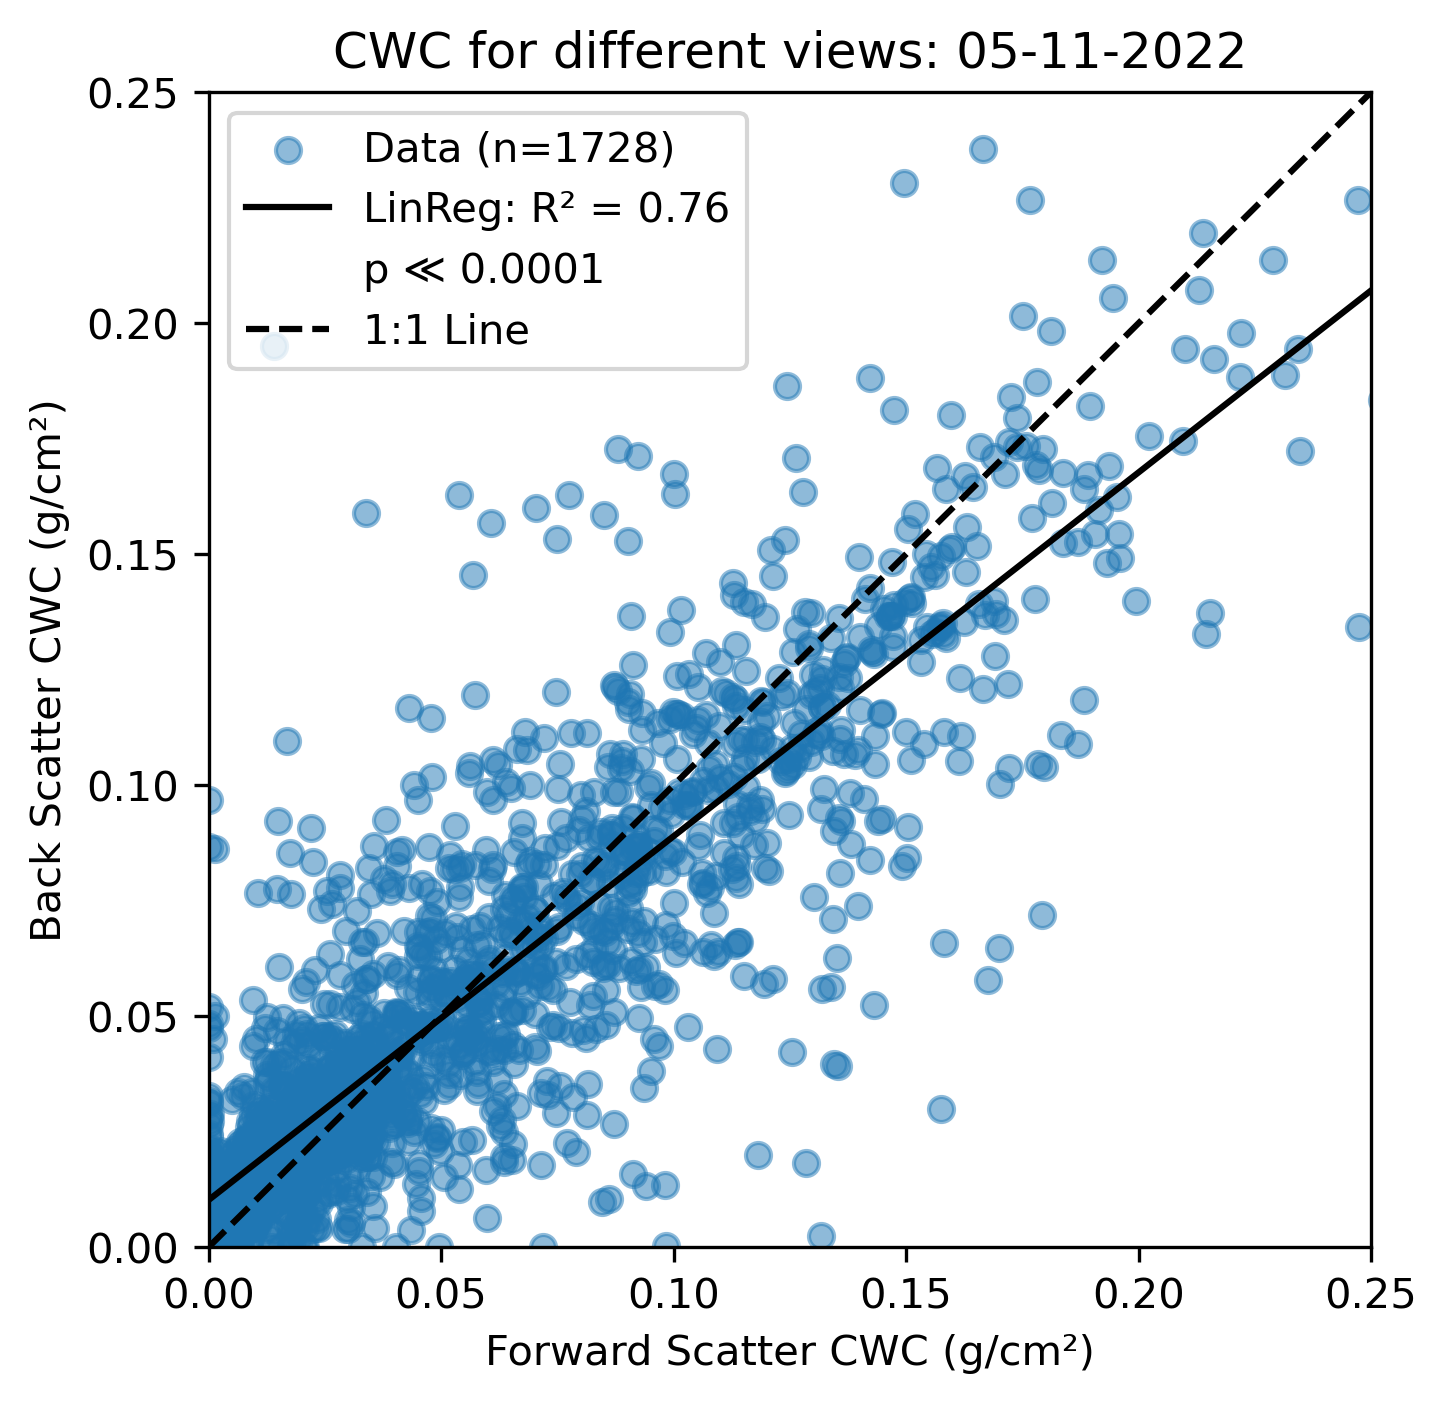

In [ ]:
# plot the CWCs
fig, ax = plt.subplots(figsize=(5,5))

# for indices where flip_flag is True, we need to flip the CWCs
cwc_backs_dup = np.array(cwc_backs)
cwc_fores_dup = np.array(cwc_fores)
cwc_backs_dup[flip_flags] = np.array(cwc_fores)[flip_flags]
cwc_fores_dup[flip_flags] = np.array(cwc_backs)[flip_flags]

ax.scatter(cwc_fores_dup, cwc_backs_dup, alpha=0.5, label='Data (n='+str(len(cwc_fores))+')')

# linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(cwc_fores, cwc_backs)
ax.plot([0, 0.25], [0*slope+intercept, 0.25*slope+intercept], color='black', label='LinReg: R² = '+str(round(r_value**2, 2)))
ax.scatter([], [], color='white', label='p ≪ 0.0001', alpha=0) # stats.linregress actually just returned p=0

ax.set_title('CWC for different views: '+ date[4:6] + '-' + date[6:8] + '-' + date[0:4])
ax.set_ylim(0, 0.25)
ax.set_xlim(0, 0.25)
ax.set_ylabel('Back Scatter CWC (g/cm²)')
ax.set_xlabel('Forward Scatter CWC (g/cm²)')
ax.plot([0, 0.25], [0, 0.25], color='black', linestyle='--', label='1:1 Line')
ax.legend()
plt.savefig('./cwc_comparison_'+date+'.png')